## Bin Clustering

In [1]:
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import gzip
import loompy
import scipy.sparse as sparse
import urllib.request
import pybedtools
import warnings
from sklearn.neighbors import NearestNeighbors
from matplotlib.collections import LineCollection

import cytograph as cg
from cytograph.decomposition import HPF
from scipy.stats import poisson
from cytograph.manifold import BalancedKNN
from cytograph.metrics import jensen_shannon_distance
# from cytograph.embedding import tsne
from cytograph.clustering import PolishedLouvain, PolishedSurprise
from cytograph.plotting import manifold

sys.path.append('/home/camiel/chromograph/')
from chromograph.plotting.QC_plot import QC_plot

from umap import UMAP
import sklearn.metrics
from scipy.spatial import distance
import community
import networkx as nx
from scipy import sparse
from typing import *

from sklearn.decomposition import IncrementalPCA

/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [12]:
## Parameters
f = '/data/proj/scATAC/chromograph/build_20200511/Midbrain/Midbrain.loom'

In [13]:
import logging

logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

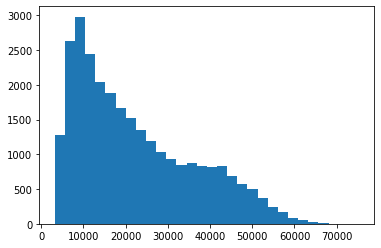

In [14]:
with loompy.connect(f, 'r') as ds:
    plt.hist(ds.ca.NBins, bins = 30)

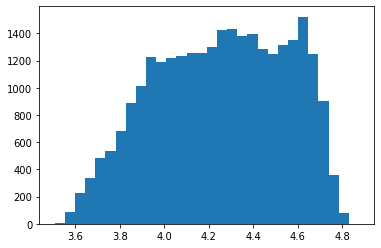

In [15]:
with loompy.connect(f, 'r') as ds:
    plt.hist(np.log10(ds.ca.NBins + 1), bins = 30)

In [ ]:
import timeit

In [42]:
with loompy.connect(f, 'r') as ds:
    print(ds.layers.keys())
    logging.info('Extracting data')
    data = ds.sparse()
    logging.info('Convert to csc')
    csc = data.tocsc()
    logging.info('Finished converting')

15:29:09 INFO     Extracting data


['', '5kb_bins', 'TF-IDF']


15:37:09 INFO     Convert to csc
15:37:30 INFO     Finished converting


In [54]:
f_temp = '/data/proj/scATAC/chromograph/tmp/test.loom'
with loompy.connect(f, 'r') as ds:
    logging.info('Extracting data')
    data = ds.sparse()
    logging.info('Convert to csc')
    csc = data.tocsc()
    logging.info('Convert to csr')
    csr = data.tocsr()
    logging.info('Generate file')
    loompy.create(filename=f_temp, 
              layers={'': data, 'csr': csr, 'csc':csc}, 
              row_attrs=ds.ra, 
              col_attrs=ds.ca,
              file_attrs=ds.attrs)

16:29:27 INFO     Extracting data
16:39:45 INFO     Convert to csc
16:39:59 INFO     Convert to csr
16:40:25 INFO     Generate file


In [55]:
with loompy.connect(f_temp, 'r') as ds:
    logging.info('Loop over main')
    for (_, selection, view) in ds.scan(axis=1, layers = ['']):
        s = view
    logging.info('Loop over csr')
    for (_, selection, view) in ds.scan(axis=1, layers = ['']):
        s = view
    logging.info('Loop over csc')
    for (_, selection, view) in ds.scan(axis=1, layers = ['']):
        s = view
    logging.info('finished')

17:31:29 INFO     Loop over main
17:38:52 INFO     Loop over csr
17:44:30 INFO     Loop over csc
17:50:09 INFO     finished


In [43]:
%%timeit

s = np.sum(data, axis = 1)
print(s.shape)

(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
1.07 s ± 9.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%%timeit

s = np.sum(csc, axis = 1)
print(s.shape)

(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
2.46 s ± 314 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%%timeit

s = np.sum(data, axis = 0)
print(s.shape)

(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
2.5 s ± 44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%%timeit

s = np.sum(csc, axis = 0)
print(s.shape)

(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
469 ms ± 9.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
with loompy.connect(f, 'r') as ds:
    print(ds.layers.keys())
    logging.info('Extracting data')
    data = ds.sparse()
    logging.info('Convert to csc')
    csr = data.tocsr()
    logging.info('Finished converting')

15:38:25 INFO     Extracting data


['', '5kb_bins', 'TF-IDF']


15:46:28 INFO     Convert to csc
15:46:50 INFO     Finished converting


In [48]:
%%timeit

s = np.sum(data, axis = 1)
print(s.shape)

(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
1.14 s ± 32.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%%timeit

s = np.sum(csr, axis = 1)
print(s.shape)

(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
(617643, 1)
479 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [50]:
%%timeit

s = np.sum(data, axis = 0)
print(s.shape)

(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
2.5 s ± 9.28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [51]:
%%timeit

s = np.sum(csr, axis = 0)
print(s.shape)

(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
(1, 27876)
1.44 s ± 307 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
logging.info('Convert to csc')
csc = data.tocsc()
logging.info('Finished converting')

12:28:24 INFO     Louvain community detection
12:37:39 INFO     Using DBSCAN to mark outliers
12:37:41 INFO     Using neighborhood to mark outliers
12:38:08 INFO     Breaking clusters
12:38:20 INFO     Smoothing cluster identity on the embedding
12:39:02 INFO     Marking tiny clusters as outliers
12:39:03 INFO     Louvain community detection
12:47:01 INFO     Using DBSCAN to mark outliers
12:47:04 INFO     Using neighborhood to mark outliers
12:47:33 INFO     Breaking clusters
12:47:43 INFO     Smoothing cluster identity on the embedding
12:48:25 INFO     Marking tiny clusters as outliers
12:48:26 INFO     resolution 0.5: 147, resolution 1: 131


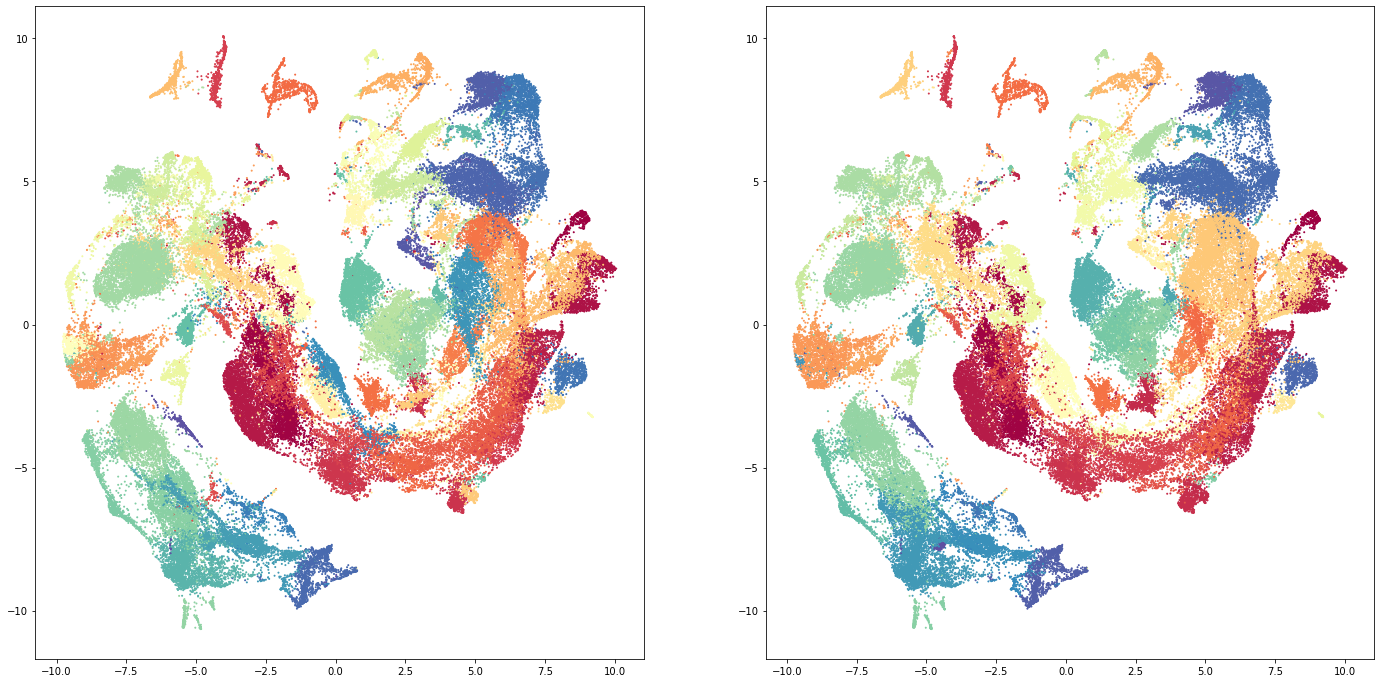

In [5]:
with loompy.connect(f, 'r') as ds:
    r = [0.5, 1]
    pl = PolishedLouvain(outliers=False, resolution=r[0], graph="RNN", embedding="TSNE", min_cells=50)
    labels = [pl.fit_predict(ds)]
    
    pl = PolishedLouvain(outliers=False, resolution=r[1], graph="RNN", embedding="TSNE", min_cells=50)
    labels.append(pl.fit_predict(ds))
    
    fig, ax = plt.subplots(1,2, figsize=(24,12))
    
    ax[0].scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c= labels[0], s=1, cmap = 'Spectral')
    ax[1].scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c= labels[1], s=1, cmap = 'Spectral')
    logging.info(f'resolution {r[0]}: {len(set(labels[0]))}, resolution {r[1]}: {len(set(labels[1]))}')

13:21:29 INFO     resolution [(0.5, 147), (1, 131), (1.5, 131), (2, 130)]


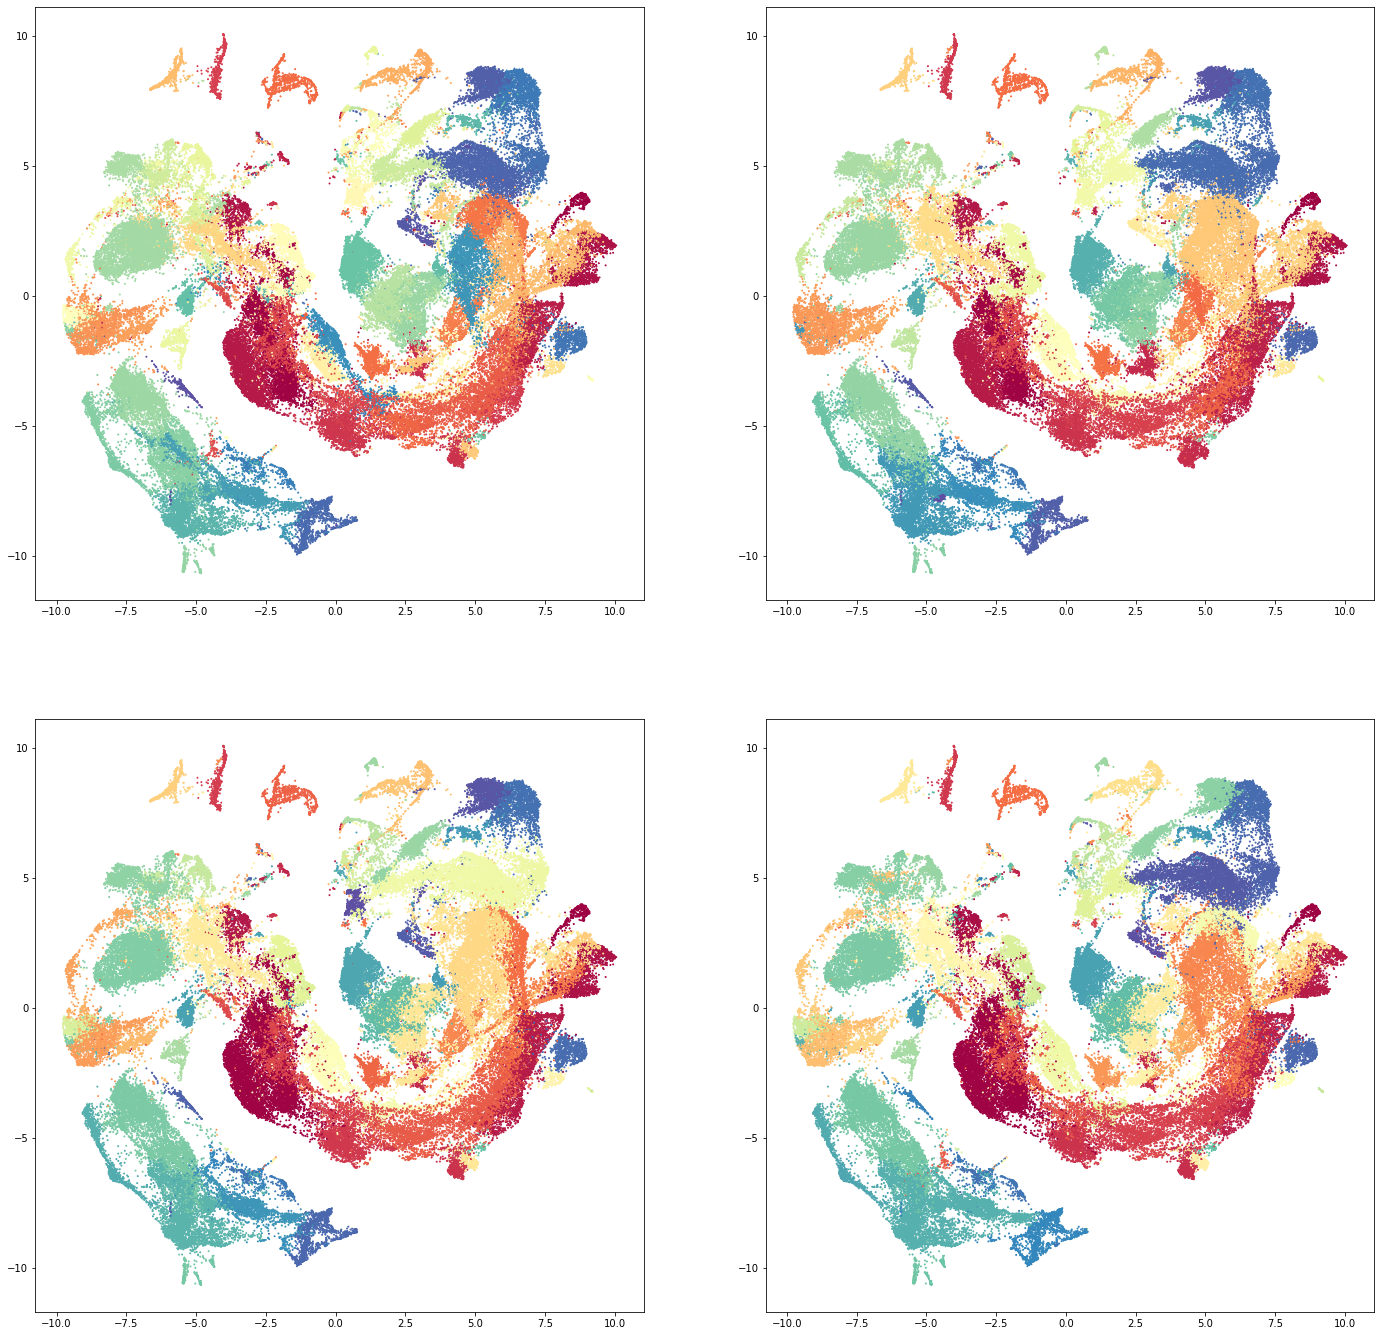

In [8]:
r = [0.5, 1, 1.5, 2]
with loompy.connect(f, 'r') as ds:
#     pl = PolishedLouvain(outliers=False, resolution=r[2], graph="RNN", embedding="TSNE", min_cells=50)
#     labels.append(pl.fit_predict(ds))
    
#     pl = PolishedLouvain(outliers=False, resolution=r[3], graph="RNN", embedding="TSNE", min_cells=50)
#     labels.append(pl.fit_predict(ds))
    
    fig, ax = plt.subplots(2,2, figsize=(24,24))
    ax = ax.flatten()
    
    ax[0].scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c= labels[0], s=1, cmap = 'Spectral')
    ax[1].scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c= labels[1], s=1, cmap = 'Spectral')
    ax[2].scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c= labels[2], s=1, cmap = 'Spectral')
    ax[3].scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c= labels[3], s=1, cmap = 'Spectral')

    logging.info(f'resolution {[(r[x], len(set(labels[x]))) for x in range(len(r))]}')

13:28:37 INFO     Louvain community detection
13:40:05 INFO     Using DBSCAN to mark outliers
13:40:09 INFO     Using neighborhood to mark outliers
13:40:39 INFO     Breaking clusters
13:40:51 INFO     Smoothing cluster identity on the embedding
13:41:34 INFO     Marking tiny clusters as outliers
13:41:35 INFO     resolution 1.5, 94


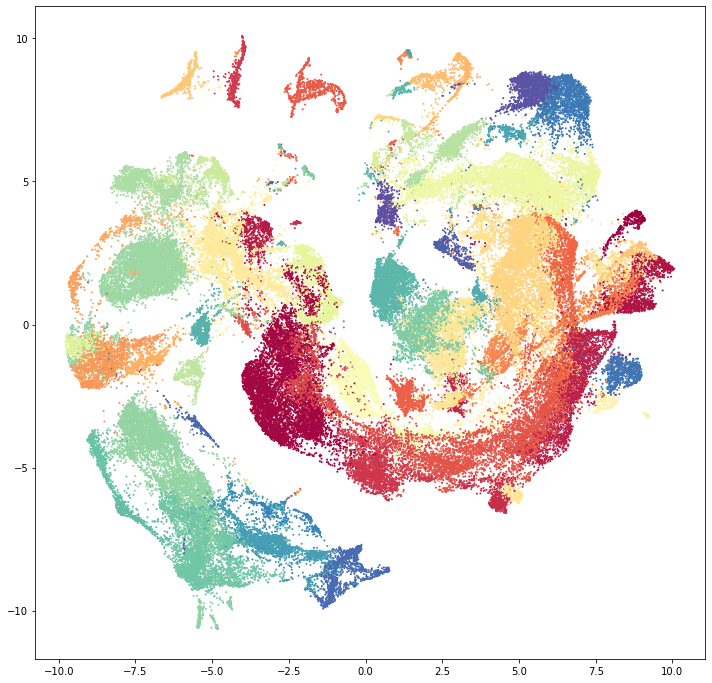

In [11]:
r = [0.5, 1, 1.5, 2]
with loompy.connect(f, 'r') as ds:
    pl = PolishedLouvain(outliers=False, resolution=1.5, graph="RNN", embedding="TSNE", min_cells=100)
    labels100 = pl.fit_predict(ds)
    
    plt.figure(figsize=(12,12))
    
    plt.scatter(ds.ca.UMAP[:,0], ds.ca.UMAP[:,1], c= labels100, s=1, cmap = 'Spectral')

    logging.info(f'resolution 1.5, {len(set(labels100))}')

In [10]:
collections.Counter(labels[3])

Counter({0: 338,
         1: 6697,
         60: 2103,
         6: 1742,
         2: 499,
         3: 723,
         7: 2766,
         8: 96,
         9: 442,
         10: 707,
         11: 1769,
         71: 593,
         12: 495,
         13: 178,
         4: 144,
         14: 3686,
         18: 266,
         26: 755,
         5: 86,
         111: 820,
         34: 986,
         55: 543,
         80: 1273,
         27: 233,
         28: 1091,
         37: 940,
         36: 224,
         38: 759,
         33: 150,
         19: 347,
         59: 390,
         20: 754,
         56: 908,
         32: 541,
         29: 93,
         43: 1527,
         53: 158,
         104: 1824,
         24: 108,
         16: 195,
         35: 70,
         50: 135,
         125: 120,
         110: 2429,
         62: 135,
         31: 3225,
         103: 145,
         66: 184,
         82: 217,
         72: 256,
         49: 622,
         23: 95,
         81: 96,
         76: 306,
         48: 130,
         

18:19:13 INFO     511
18:19:14 INFO     1023
18:19:15 INFO     1535
18:19:15 INFO     2047
18:19:16 INFO     2559
18:19:16 INFO     3071
18:19:17 INFO     3583
18:19:18 INFO     4095
18:19:18 INFO     4607
18:19:19 INFO     5119
18:19:20 INFO     5631
18:19:20 INFO     6143
18:19:21 INFO     6655
18:19:21 INFO     7167
18:19:22 INFO     7679
18:19:23 INFO     8191
18:19:23 INFO     8703
18:19:24 INFO     9215
18:19:24 INFO     9507


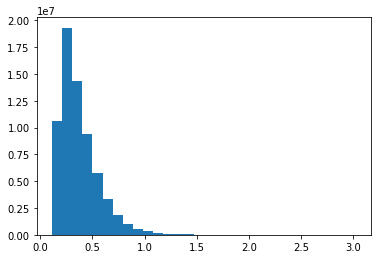

In [43]:
from chromograph.pipeline.utils import div0

samp = '10X232_1'
ft = f'/data/proj/scATAC/samples/{samp}/{samp}_GA.loom'
with loompy.connect(ft, 'r') as ds:
    GA_rowsum = ds.map([np.count_nonzero], axis=0)[0]
    GA_colsum = ds.map([np.count_nonzero], axis=1)[0]
    
    norm = np.zeros(ds.shape)
    for (ix, selection, view) in ds.scan(axis=1):
        norm[:,selection] = div0(view[:,:], GA_colsum[selection]) * int('5000')
        logging.info(f'{max(selection)}')
    
    plt.hist(np.log10(norm[norm > 0]+1), bins = 30)
    plt.show()

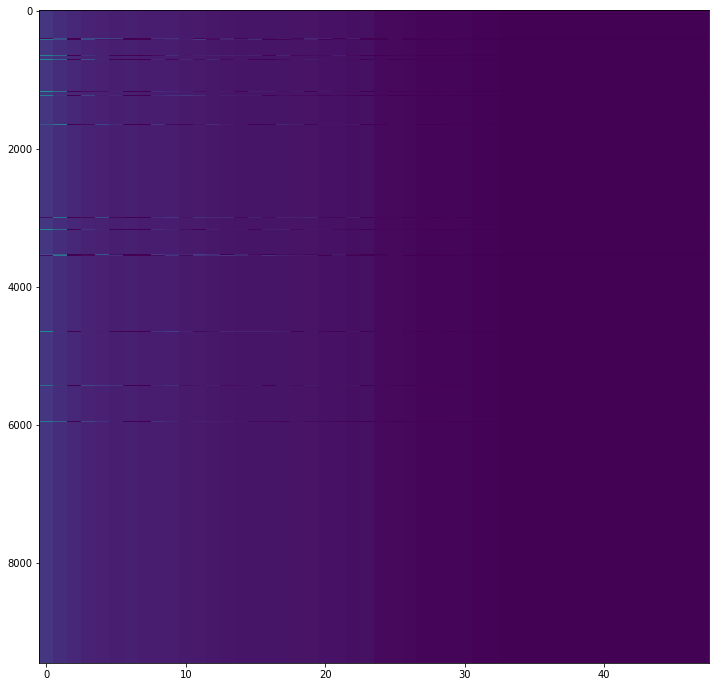

In [135]:
ft = '/data/proj/scATAC/chromograph/build_20200216/Midbrain_peaks.loom'

with loompy.connect(ft, 'r') as ds:
#     print(ds.shape)
    
#     peak_rowsum = ds.map([np.count_nonzero], axis=0)[0]
#     peak_colsum = ds.map([np.count_nonzero], axis=1)[0]
    
#     plt.hist(peak_rowsum, bins = 30, alpha=.5)
#     plt.show()
#     plt.hist(np.log10(peak_rowsum), bins = 30, alpha=.5)
#     plt.show()
#     plt.hist(peak_colsum, bins = 30, alpha=.5)
#     plt.show()
#     plt.scatter(ds.ca['TSNE'][:,0], ds.ca['TSNE'][:,1])

(array([1.0000e+00, 3.0000e+00, 4.0000e+00, 1.1000e+01, 5.1000e+01,
        1.0200e+02, 3.6100e+02, 9.1500e+02, 1.9080e+03, 4.1880e+03,
        8.5570e+03, 1.3445e+04, 1.9590e+04, 2.4128e+04, 2.5153e+04,
        2.3720e+04, 2.2430e+04, 2.0140e+04, 1.7998e+04, 1.5774e+04,
        1.3386e+04, 1.1422e+04, 9.5740e+03, 7.9680e+03, 5.9910e+03,
        4.8310e+03, 4.2420e+03, 4.8650e+03, 6.7120e+03, 2.7430e+03]),
 array([-3.61556443, -3.407178  , -3.19879156, -2.99040513, -2.7820187 ,
        -2.57363226, -2.36524583, -2.1568594 , -1.94847297, -1.74008653,
        -1.5317001 , -1.32331367, -1.11492723, -0.9065408 , -0.69815437,
        -0.48976794, -0.2813815 , -0.07299507,  0.13539136,  0.3437778 ,
         0.55216423,  0.76055066,  0.96893709,  1.17732353,  1.38570996,
         1.59409639,  1.80248283,  2.01086926,  2.21925569,  2.42764212,
         2.63602856]),
 <a list of 30 Patch objects>)

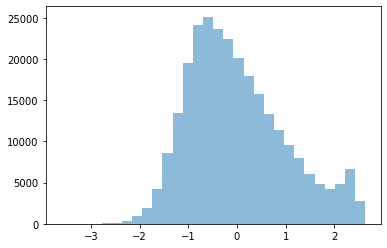

In [53]:
cov = np.log10(peak_rowsum+1)
mu = np.mean(cov)
sd = np.std(cov)
Z = (cov - mu) / sd

plt.hist(Z, bins = 30, alpha=.5)

In [54]:
print(9452/2)
print(10**3.5)
print(10**1.5)
np.log10(45)

4726.0
3162.2776601683795
31.622776601683793


1.6532125137753437

In [127]:
ft = '/data/proj/scATAC/chromograph/build_20200220_Midbrain/Midbrain.loom'
with loompy.connect(ft, 'r') as ds:
#     rows = np.array((ds.ra['NCells'] > (0.02*ds.shape[1])) & (ds.ra['NCells'] < (0.4*ds.shape[1]))==1)
#     print(ds['TF_IDF'].sparse(rows=rows).shape)
#     plt.scatter(ds.ca['UMAP'][:,0], ds.ca['UMAP'][:,1])


[]


In [77]:
logging.info(f'Sparsity for peaks after selection: {18860515/142421/9452}')
logging.info(f'Sparsity for peaks after selection: {18860515/142421/9452}')

14:08:19 INFO     Sparsity for peaks after selection: 0.014010569974745679


In [113]:
for samp in ['10X232_1', '10X232_2', '10X232_3', '10X232_4']:
    ft = f'/data/proj/scATAC/samples/{samp}/{samp}_5kb.loom'

    with loompy.connect(ft, 'r') as ds:
#         NCells = ds.map([np.count_nonzero], axis=0)[0]
#         NCounts = ds.map([np.count_nonzero], axis=1)[0]
#         print(NCounts)
#         print(f'Sparsity for bins: {ds.sparse().nnz/(ds.shape[0]*ds.shape[1])}')
        print(ds.ra.loc[0])

chr1:1-5000
chr1:1-5000
chr1:1-5000
chr1:1-5000


In [123]:
ft = '/data/proj/scATAC/chromograph/build_20200213/Cerebellum_GA.loom'
with loompy.connect(ft, 'r') as ds:
    print(sum(ds.ca['passed_filters'][ds.ca.Clusters == 2]))

145720779


In [70]:
import numpy as np
from typing import List

import loompy
from chromograph.pipeline.utils import div0

class TF_IDF:
    """
    Calculate the Term-Frequency Inverse Data Frequency (TF-IDF) values, dealing properly 
    with edge cases such as division by zero.
    """
    def __init__(self, layer: str = "") -> None:
        self.IDF = None  # type: np.ndarray
        self.totals = None  # type: np.ndarray
        self.layer = layer
        self.level = 0

    def fit(self, ds: loompy.LoomConnection) -> None:
        self.IDF = np.zeros(ds.shape[0])  ## Row totals
        self.totals = np.zeros(ds.shape[1])  ## Column totals
        N = ds.shape[1]

        ## Scan over rows (all cells) and add to column totals
        for _, selection, view in ds.scan(axis=0):
            vals = view[self.layer][:, :].astype("float")
            self.totals += np.sum(vals, axis=0)
            
            ## Set row totals
            NB = np.sum(view[self.layer][:, :]>0, axis=1)
            self.IDF[selection] = np.log10(div0(N,NB)+1)
            
        ## Set level to normalize to
        self.level = np.median(self.totals)


    def transform(self, vals: np.ndarray, cells: np.ndarray = None) -> np.ndarray:
        """
        Calculate the TF-IDF score for array using the previously calculated aggregate statistics
        Args:
            vals (ndarray):		Matrix of shape (n_genes, n_cells)
            cells (ndarray):	Optional indices of the cells that are represented in vals
        Returns:
            vals_adjusted (ndarray):	The normalized values
        """
        # Compute the Term-Frequency for selected cells
        if cells is None:
            cells = slice(None)
        vals = vals.astype("float")
        vals = div0(vals, self.totals[cells]) * self.level
        
        ## Multiply by Inverse Data Frequency
        vals = vals*self.IDF[:,None]
        
        return vals

    def fit_transform(self, vals: np.ndarray, cells: np.ndarray = None) -> np.ndarray:
        self.fit(ds)
        return self.transform(vals, cells)

In [ ]:
build = '/data/proj/scATAC/chromograph/build_20191205/'
with loompy.connect(os.path.join(build, 'Midbrain.loom'), 'r') as ds:
    tf_idf = TF_IDF()
    tf_idf.fit(ds)
    X = np.zeros((ds.shape[0], ds.shape[1]))
    for (ix, selection, view) in ds.scan(axis=1):
        X[:,selection] = tf_idf.transform(view[:,:], selection)
        logging.info(f'transformed {max(selection)} cells')

In [75]:
mx = np.max(X, axis=0)
my = np.max(X, axis=1)

(array([5.23349e+05, 8.16950e+04, 9.47200e+03, 2.17900e+03, 6.55000e+02,
        1.88000e+02, 6.70000e+01, 2.20000e+01, 1.00000e+01, 6.00000e+00]),
 array([  0.        ,  14.29303351,  28.58606703,  42.87910054,
         57.17213405,  71.46516757,  85.75820108, 100.05123459,
        114.34426811, 128.63730162, 142.93033514]),
 <a list of 10 Patch objects>)

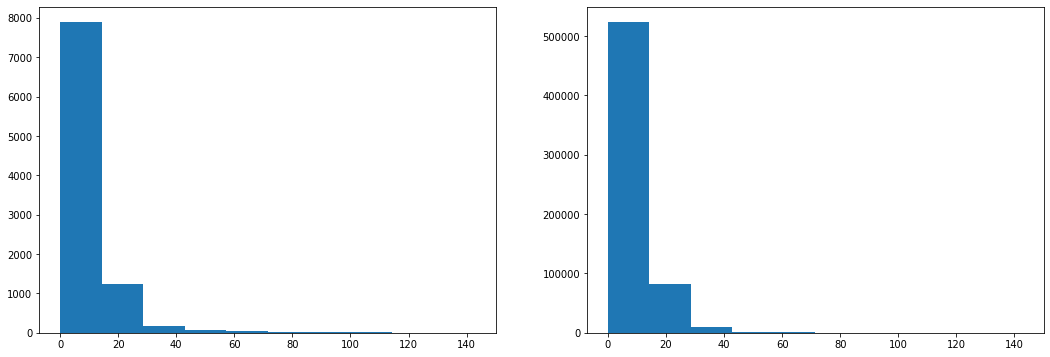

In [79]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(121)
ax1.hist(mx)
ax2 = fig.add_subplot(122)
ax2.hist(my)

In [11]:
if not os.path.isdir(outdir):
    os.mkdir(outdir)

In [ ]:
ds = loompy.connect(f, mode='r')
print(ds.shape)
print(ds.ra.keys())

In [ ]:
blayer = '{}kb_bins'.format(int(ds.attrs['bin_size'] / 1000))
blayer

In [ ]:
## nonzero (nnz) counts per bin
NCells = ds.map([np.count_nonzero], axis=0)[0]
NBins = ds.map([np.count_nonzero], axis=1)[0]

In [ ]:
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(121)
ax1.hist(NCells, bins=30, alpha=.5)
ax1.set_title('Number of cells with positive bin')

ax2 = fig.add_subplot(122)
ax2.hist(NBins, bins=30, alpha=.5)
ax2.set_title('Number of positive bins per cell')

In [ ]:
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(121)
ax1.hist(np.log10(NCells +1), bins=30, alpha=.5)
ax1.set_title('Number of cells with positive bin')

ax2 = fig.add_subplot(122)
ax2.hist(np.log10(NBins+1), bins=30, alpha=.5)
ax2.set_title('Number of positive bins per cell')

In [ ]:
## Calculate coverage
cov = np.log10(NCells+1)
mu = np.mean(cov)
sd = np.std(cov)
cov = (cov - mu) / sd
# ds.ra['Coverage'] = (cov - mu) / sd

In [ ]:
fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(111)
ax1.hist(cov, bins=30, alpha=.5)
ax1.set_title('Number of cells with positive bin')

In [11]:
bins = (cov > -1.75) & (cov < 1.75)

In [12]:
## Select bins for PCA fitting
bins = (cov > -1.75) & (cov < 1.75)
PCA = IncrementalPCA(n_components=50)
for (ix, selection, view) in ds.scan(axis=1):
    PCA.partial_fit(view[blayer][bins, :].T > 0)
    logging.info(f'Fitted {ix + selection.shape[1]} cells to PCA')

17:33:40 INFO     Fitted 0 cells to PCA
17:34:52 INFO     Fitted 512 cells to PCA
17:36:01 INFO     Fitted 1024 cells to PCA
17:37:00 INFO     Fitted 1536 cells to PCA
17:37:52 INFO     Fitted 2048 cells to PCA
17:38:45 INFO     Fitted 2560 cells to PCA
17:39:40 INFO     Fitted 3072 cells to PCA
17:40:51 INFO     Fitted 3584 cells to PCA
17:42:04 INFO     Fitted 4096 cells to PCA
17:43:33 INFO     Fitted 4608 cells to PCA
17:45:04 INFO     Fitted 5120 cells to PCA
17:46:31 INFO     Fitted 5632 cells to PCA
17:47:43 INFO     Fitted 6144 cells to PCA
17:48:48 INFO     Fitted 6656 cells to PCA
17:49:57 INFO     Fitted 7168 cells to PCA
17:50:59 INFO     Fitted 7680 cells to PCA
17:51:52 INFO     Fitted 8192 cells to PCA
17:52:45 INFO     Fitted 8704 cells to PCA
17:53:13 INFO     Fitted 9216 cells to PCA


In [ ]:
## Transforming data
PCs = np.zeros((50, ds.shape[1]))
logging.info(f'Transforming data')
for (ix, selection, view) in ds.scan(axis=1):
    X = PCA.transform(view[blayer][bins,:].T)
    PCs[ix: ix + selection.shape[0], :] = X
    logging.info(f'Finished transforming {ix+ selection.shape[1]} cells')

17:53:15 INFO     Transforming data


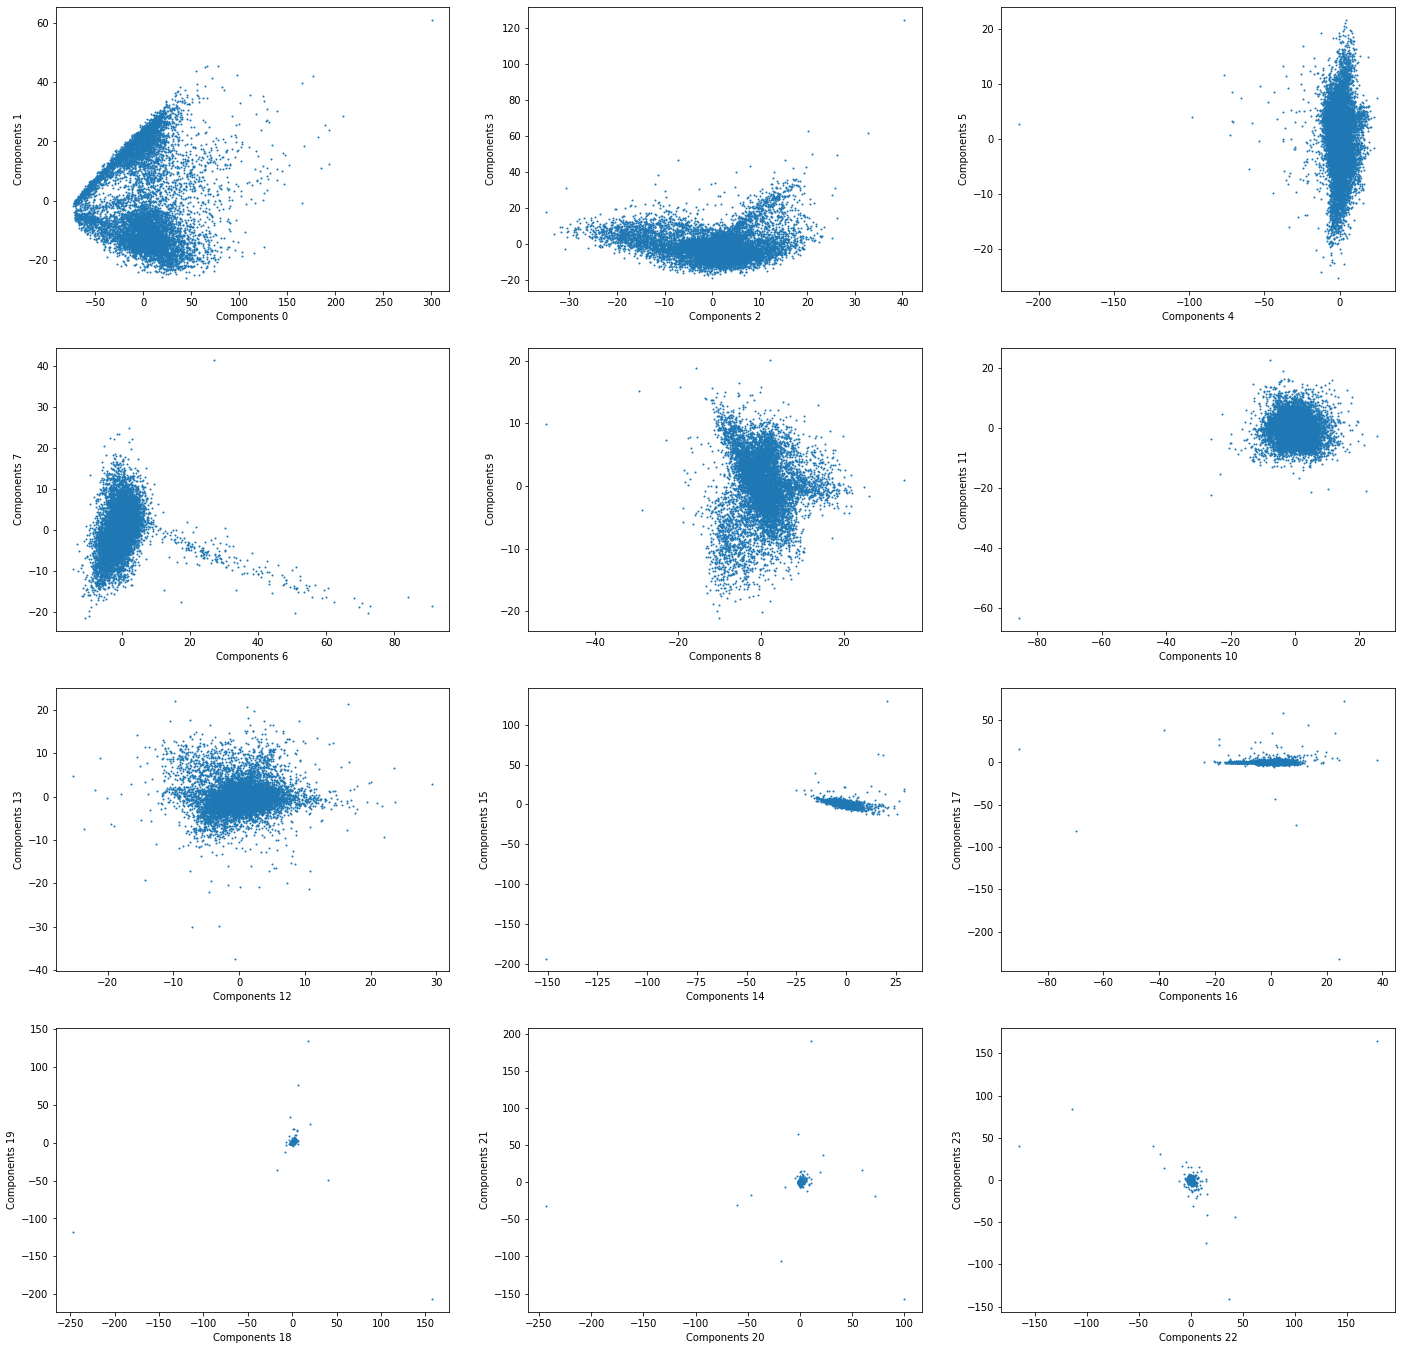

In [80]:
## Let's plot the first few components
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize=(24,24))

y = -1
x = 0
for k in range(int(24/2)):
    x = k%3
    if x == 0:
        y += 1    

    ax[y,x].scatter(ds.ca['PCA'][:,(2*k)], ds.ca['PCA'][:,(2*k+1)], s=1)
    ax[y,x].set_xlabel(f'Components {2*k}')
    ax[y,x].set_ylabel(f'Components {2*k+1}')
#     ax[y,x].set_title(f'Component {2*k} vs Component {2*k+1}')

In [2]:
config.paths

NameError: name 'config' is not defined

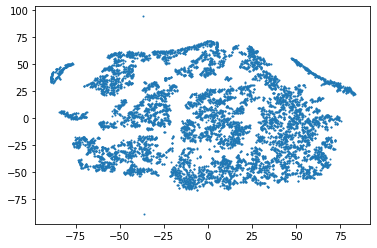

In [89]:
from sklearn.manifold import TSNE

tsne = TSNE()
tsne.fit(ds.ca['PCA'])
plt.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1], s=1)

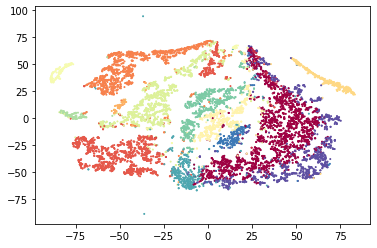

In [90]:
plt.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1], s=1, c=ds.ca['Clusters'], cmap='Spectral')

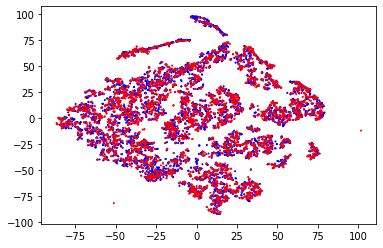

In [37]:
col = {'10X232_3': 'blue', '10X232_4': 'red'}

plt.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1], s=1, c=[col[x] for x in ds.ca['sample']])

In [187]:
from chromograph.pipeline import config
import shutil

with loompy.connect('/data/proj/scATAC/chromograph/build_20191206/Cerebellum.loom', mode = 'r') as ds:
    config = config.load_config()
    pf = os.path.join(config.paths.build, 'peaks')

    if not os.path.isdir(pf):
        os.mkdir(pf)   

    chunks = []
    for i in np.unique(ds.ca['Clusters']):
        cells = ds.ca["sample", "barcode"][ds.ca['Clusters'] == i]
        files = [os.path.join(config.paths.samples, x[0], 'fragments', f'{x[1]}.tsv.gz') for x in cells]
        chunks.append([i,files])

    logging.info('Start merging fragments by cluster')
    piles = []
    for ck in chunks:
        files = np.array(ck[1])
        ex = np.array([os.path.exists(x) for x in files])
        files = files[ex]

        fmerge = os.path.join(pf, f'fragments_{ck[0]}.tsv.gz')
        with open(fmerge, 'wb') as out:
            for f in files:
                with open(f, 'rb') as file:
                    shutil.copyfileobj(file, out)
        piles.append([ck[0], fmerge])
        logging.info(f'Finished with cluster {ck[0]}')

/home/camiel/chromograph/notebooks/peaks/fragments_0.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_1.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_2.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_3.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_4.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_5.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_6.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_7.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_8.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_9.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_10.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_11.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_12.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_13.tsv.gz
/home/camiel/chromograph/notebooks/peaks/fragments_14.tsv.gz


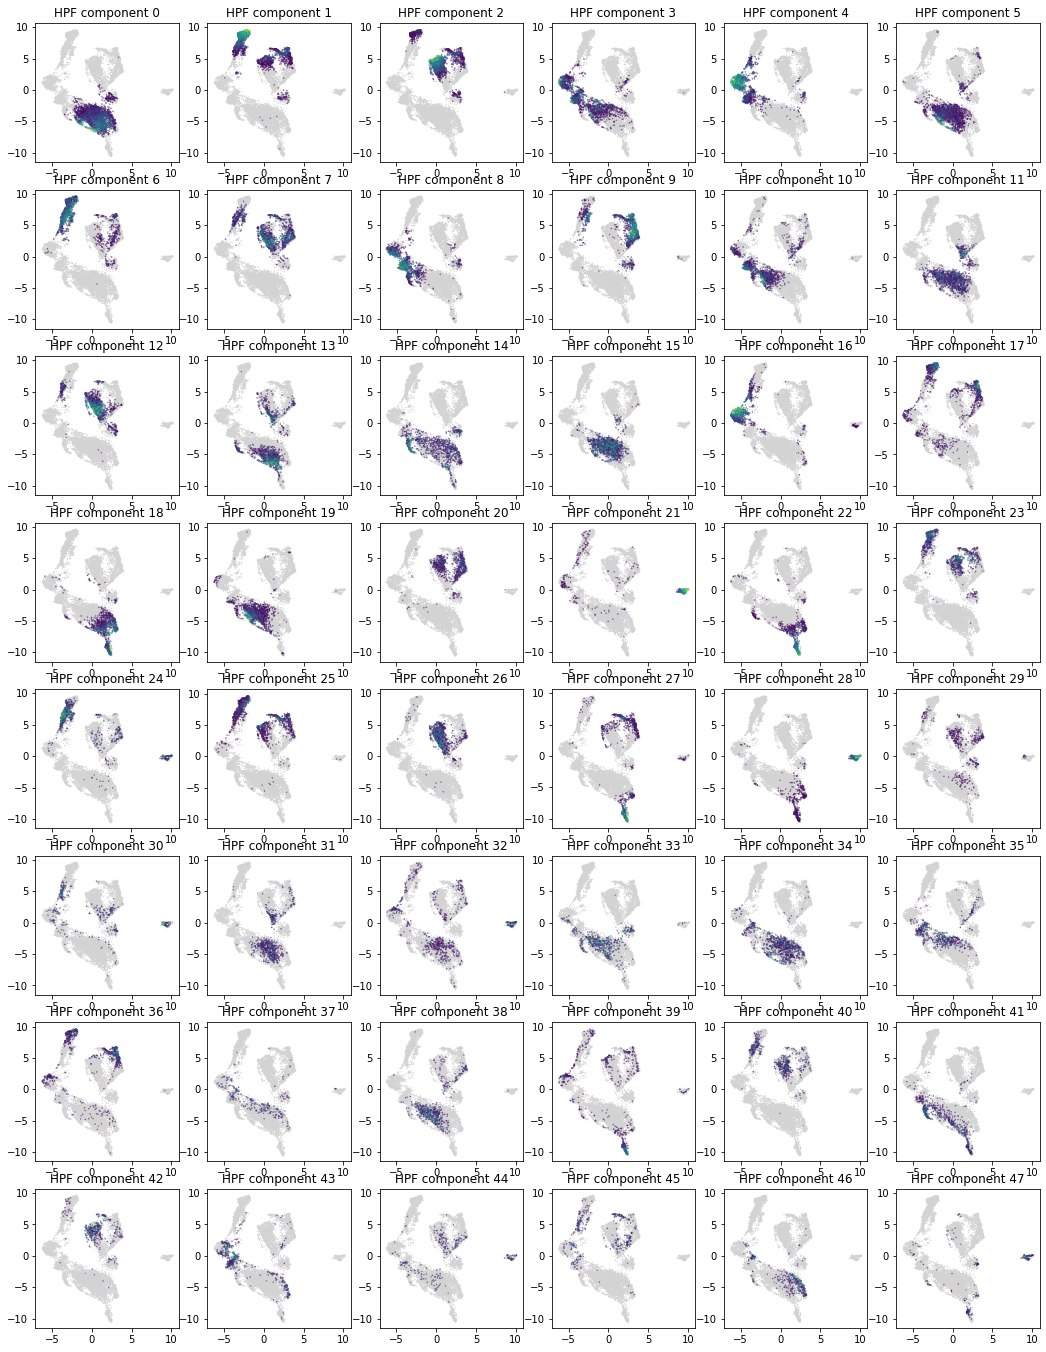

In [55]:
f

    ## Plot HPF factors
    fig, ax = plt.subplots(nrows = 8, ncols = 6, figsize=(18,24))

    ncomp = ds.ca.HPF.shape[1]
    mComp = 0.05

    y = -1
    x = 0
    for k in range(ncomp):
        x = k%6
        if x == 0:
            y += 1    

        ax[y,x].scatter(ds.ca['UMAP'][:,0], ds.ca['UMAP'][:,1], s=0.1, color = 'lightgray')

        ck = ds.ca['HPF'][:,k] > mComp
        ax[y,x].scatter(ds.ca['UMAP'][ck,0], ds.ca['UMAP'][ck,1], s=0.1, c=ds.ca['HPF'][ck,k], cmap = 'viridis')
        ax[y,x].set_title(f'HPF component {k}')

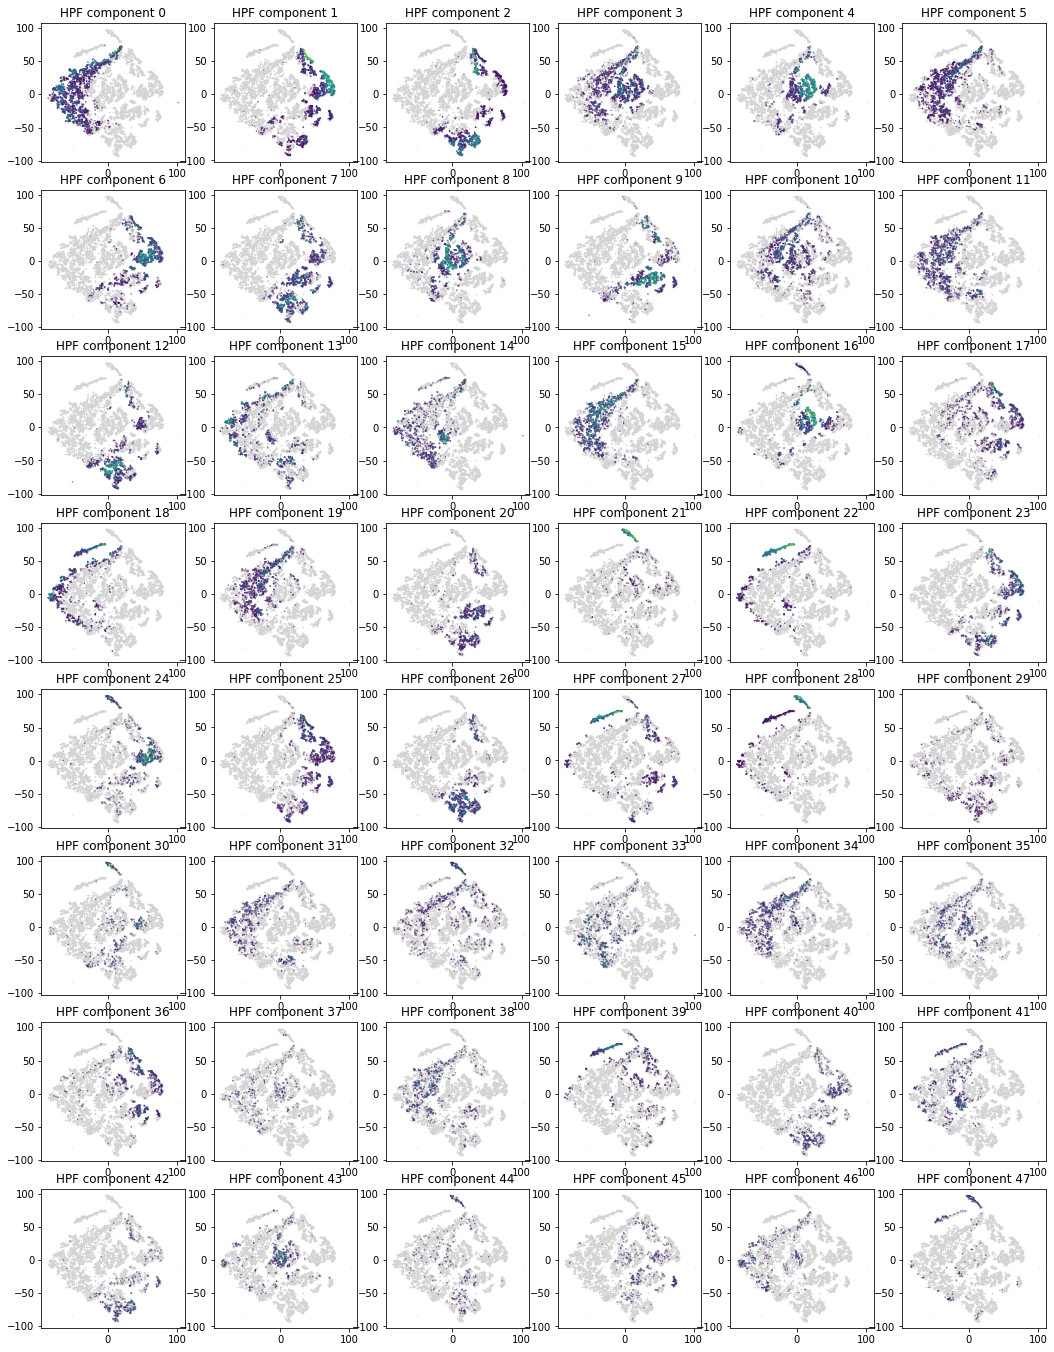

In [56]:
## Let's plot the first few components
fig, ax = plt.subplots(nrows = 8, ncols = 6, figsize=(18,24))

ncomp = ds.ca.HPF.shape[1]
mComp = 0.05

y = -1
x = 0
for k in range(ncomp):
    x = k%6
    if x == 0:
        y += 1    

    ax[y,x].scatter(tsne.embedding_[:,0], tsne.embedding_[:,1], s=0.1, color = 'lightgray')
    
    ck = ds.ca['HPF'][:,k] > mComp
    ax[y,x].scatter(tsne.embedding_[ck,0], tsne.embedding_[ck,1], s=0.1, c=ds.ca['HPF'][ck,k], cmap = 'viridis')
    ax[y,x].set_title(f'HPF component {k}')

In [57]:
ds.ra.keys()

['Accession',
 'Coverage',
 'Distance',
 'Gene',
 'HPF',
 'HPF_beta',
 'ID',
 'NCells',
 'Pval_Zscore',
 'Zscore',
 'chrom',
 'end',
 'start']

In [ ]:
if "nn" in self.config.steps or "clustering" in self.config.steps:
    if self.config.params.nn_space in ["PCA", "auto"] and "PCA" in ds.ca:
        transformed = ds.ca.PCA
        metric = "euclidean"
    elif self.config.params.nn_space in ["HPF", "auto"] and "HPF" in ds.ca:
        transformed = ds.ca.HPF
        metric = "js"
    logging.info(f"Computing balanced KNN (k = {self.config.params.k}) in {self.config.params.nn_space} space using the '{metric}' metric")
    bnn = BalancedKNN(k=self.config.params.k, metric=metric, maxl=2 * self.config.params.k, sight_k=2 * self.config.params.k, n_jobs=-1)
    bnn.fit(transformed)
    knn = bnn.kneighbors_graph(mode='distance')
    knn.eliminate_zeros()
    mknn = knn.minimum(knn.transpose())
    # Convert distances to similarities
    max_d = knn.data.max()
    knn.data = (max_d - knn.data) / max_d
    mknn.data = (max_d - mknn.data) / max_d
    ds.col_graphs.KNN = knn
    ds.col_graphs.MKNN = mknn
    mknn = mknn.tocoo()
    mknn.setdiag(0)
    # Compute the effective resolution
    d = 1 - knn.data
    radius = np.percentile(d, 90)
    logging.info(f"  90th percentile radius: {radius:.02}")
    ds.attrs.radius = radius
    inside = mknn.data > 1 - radius
    rnn = sparse.coo_matrix((mknn.data[inside], (mknn.row[inside], mknn.col[inside])), shape=mknn.shape)
    ds.col_graphs.RNN = rnn

13:19:43 INFO     Constructing nearest-neighbor graph


In [16]:
from chromograph.pipeline import config

config = config.load_config()

config.paths.bedtools

'/data/bin/bedtools2/bin/'

In [18]:
config.params

Config(batch_keys=[], clusterer='louvain', factorization='PCA', k=25, k_pooling=10, max_fraction_MT_genes=0.05, min_fraction_good_cells=0.4, min_frags=5000, n_factors=50, nn_space='auto', passedQC=False, skip_metadata=False, skip_missing_samples=False)

In [23]:
bins = (ds.ra['Coverage'] > -2) & (ds.ra['Coverage'] < 2)
print(f'{sum(bins)} out of {len(bins)}')

566823 out of 617643


In [ ]:
def jaccard(s1, s2):
    jac = s1 + s2
    return sum(jac == 2)/sum(jac > 0)
sel = np.logical_and(ds.ra['NCells'] < np.quantile(ds.ra['NCells'],0.99), ds.ra['NCells'] > 100)
data = ds.view[sel,:]

In [ ]:
from sklearn.metrics import pairwise_distances

# sim2 = np.zeros((data.shape[1], data.shape[1]))

D = pairwise_distances(data[blayer][:,:].T, metric = "jaccard")

In [ ]:
import scipy.cluster.hierarchy as sch

# Compute and plot dendrogram.
fig = plt.figure()
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = sch.linkage(D, method='centroid')
Z = sch.dendrogram(Y, orientation='right')
axdendro.set_xticks([])
axdendro.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
D = D[index,:]
D = D[:,index]
im = axmatrix.matshow(D, aspect='auto', origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
plt.colorbar(im, cax=axcolor)

# Display and save figure.
fig.show()

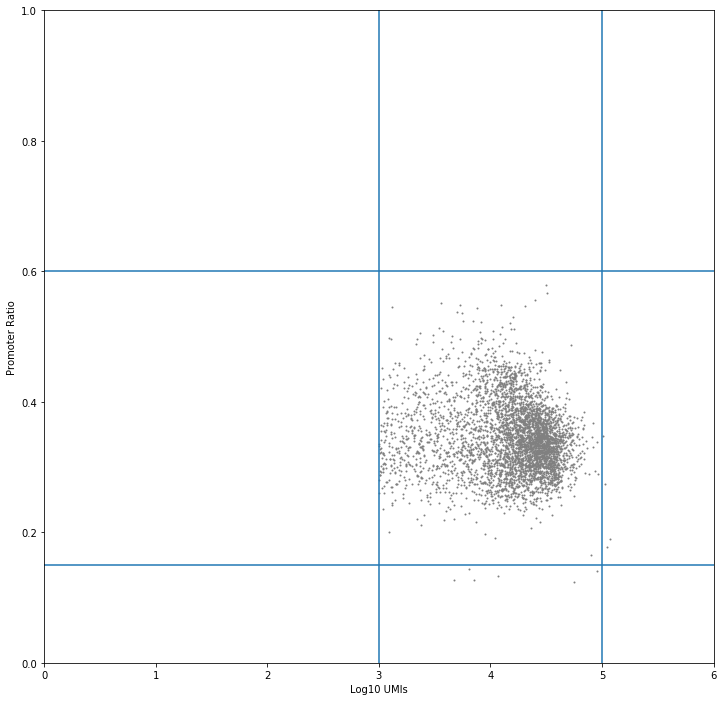

In [12]:
## --- TO BE ADDED, CURRENTLY USING CELLRANGER DEFAULT FILTERS ---
## Remove outlier cells

UMIs = np.log10(ds.ca['passed_filters'] + 1)
Prom_rat = (ds.ca['promoter_region_fragments'] + 1) / (ds.ca['passed_filters'] + 1)

fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(UMIs, Prom_rat, s=1, c='grey')
ax.set_xlabel('Log10 UMIs')
ax.set_ylabel('Promoter Ratio')

plt.axvline(x=3)
plt.axvline(x=5)
plt.axhline(0.15)
plt.axhline(0.60)

ax.set_xlim((0,6))
ax.set_ylim((0,1))

ds.ca['_Valid'] = np.logical_and(UMIs > 3, UMIs < 5)

961.0


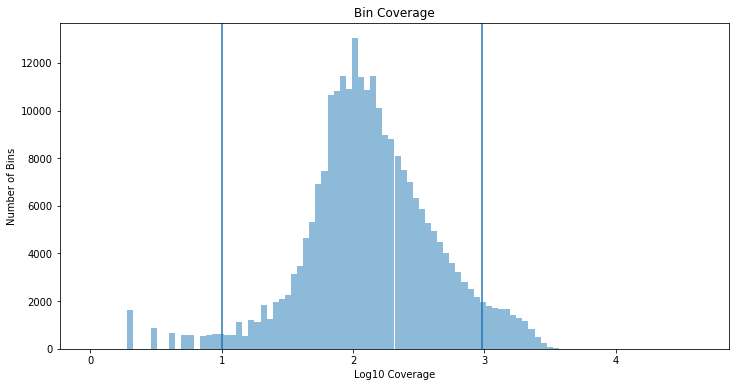

In [33]:
## Select valid bins
## --- This must be consistent between all experiments if data is to be compared
## --- Formalize this later

## nonzero (nnz) counts per bin
ds.ra['NCells'] = ds.map([np.count_nonzero], axis=0)[0]
nnz_l = np.log10(ds.ra['NCells'] + 1)
bin_cutoff = np.quantile(nnz, 0.99)
print(bin_cutoff)

plt.figure(figsize=(12,6))

plt.hist(nnz_l[nnz > 0], bins=100, alpha=0.5, range=(0, np.log10(ds.shape[1])+0.5))
plt.title("Bin Coverage")
plt.ylabel("Number of Bins")
plt.xlabel("Log10 Coverage")
plt.axvline(x=np.log10(bin_cutoff))
plt.axvline(x=1)

Text(0.5, 0, 'Number of positive bins')

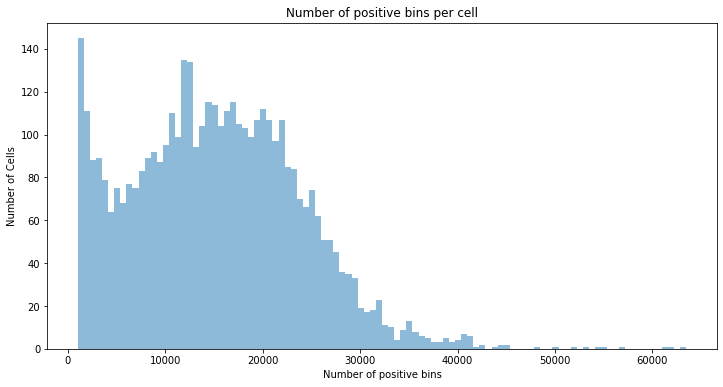

In [34]:
ds.ca['NBins'] = ds.map([np.count_nonzero], axis=1)[0]

plt.figure(figsize=(12,6))

# plt.hist(ds.ca['NBins'], bins=100, alpha=0.5, range=(0, max(ds.ca['NBins'])*1.1))
plt.hist(ds.ca['NBins'], bins=100, alpha=0.5)
plt.title("Number of positive bins per cell")
plt.ylabel("Number of Cells")
plt.xlabel("Number of positive bins")
# plt.axvline(x=np.log10(bin_cutoff))
# plt.axvline(x=1)


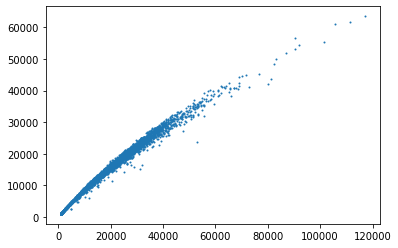

In [64]:
plt.scatter(ds.ca['passed_filters'], ds.ca['NBins'], s=1)

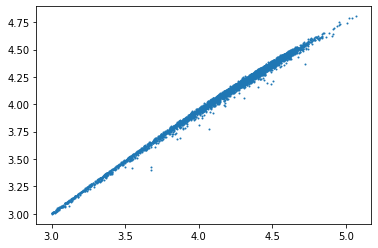

In [65]:
plt.scatter(np.log10(ds.ca['passed_filters']), np.log10(ds.ca['NBins']), s=1)

Text(0.5, 0, 'Number of positive bins')

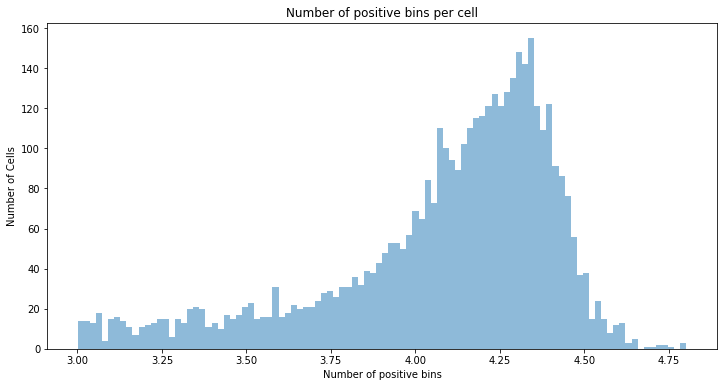

In [38]:
plt.figure(figsize=(12,6))

# plt.hist(ds.ca['NBins'], bins=100, alpha=0.5, range=(0, max(ds.ca['NBins'])*1.1))
plt.hist(np.log10(ds.ca['NBins']), bins=100, alpha=0.5)
plt.title("Number of positive bins per cell")
plt.ylabel("Number of Cells")
plt.xlabel("Number of positive bins")
# plt.axvline(x=np.log10(bin_cutoff))
# plt.axvline(x=1)

In [46]:
## Select the bins that pass filtering
bins = np.logical_and(nnz > 10, nnz < bin_cutoff)
print(sum(bins))

232016


## HPF factorization

In [47]:
## Create binary layer
ds.layers[blayer] = np.clip(ds[:,:], 0, 1)

In [48]:
# Load the data for the selected genes
data = ds[blayer].sparse(rows=bins).T
data

<4273x232016 sparse matrix of type '<class 'numpy.int64'>'
	with 43894665 stored elements in COOrdinate format>

In [49]:
# HPF factorization
hpf = HPF(k=96, validation_fraction=0.05, min_iter=10, max_iter=200, compute_X_ppv=False, n_threads=8)
hpf.fit(data)

13:35:26 INFO     HPF to 96 factors using 8 threads


HPF (nnz=41,699,931):  20%|█▉        | 40/201 [1:37:17<6:31:37, 145.95s/it, diff=-.00133, ll=-5.68e+6]


In [50]:
logging.info("Adding Betas and Thetas to loom file")
beta_all = np.zeros((ds.shape[0], hpf.beta.shape[1]))
beta_all[bins] = hpf.beta
# beta_all = hpf.beta
# Save the unnormalized factors
ds.ra.HPF_beta = beta_all
ds.ca.HPF_theta = hpf.theta
# Here we normalize so the sums over components are one, because JSD requires it
# and because otherwise the components will be exactly proportional to cell size
theta = (hpf.theta.T / hpf.theta.sum(axis=1)).T
beta = (hpf.beta.T / hpf.beta.sum(axis=1)).T
beta_all[bins] = beta
# beta_all = beta
# Save the normalized factors
ds.ra.HPF = beta_all
ds.ca.HPF = theta

15:13:30 INFO     Adding Betas and Thetas to loom file


In [51]:
logging.info("Calculating posterior probabilities")

# Expected values
exp = "{}_expected".format(blayer)
n_samples = ds.shape[1]

ds[exp] = 'float32'  # Create a layer of floats
log_posterior_proba = np.zeros(n_samples)
theta_unnormalized = hpf.theta
data = data.toarray()
start = 0
batch_size = 6400
beta_all = ds.ra.HPF_beta  # The unnormalized beta

while start < n_samples:
    # Compute PPV (using normalized theta)
    ds[exp][:, start: start + batch_size] = beta_all @ theta[start: start + batch_size, :].T
    # Compute PPV using raw theta, for calculating posterior probability of the observations
    ppv_unnormalized = beta @ theta_unnormalized[start: start + batch_size, :].T
    log_posterior_proba[start: start + batch_size] = poisson.logpmf(data.T[:, start: start + batch_size], ppv_unnormalized).sum(axis=0)
    start += batch_size
ds.ca.HPF_LogPP = log_posterior_proba

15:13:33 INFO     Calculating posterior probabilities


## Nearest neighbor graph

In [52]:
logging.info("Constructing nearest-neighbor graph")

bnn = BalancedKNN(k=25, metric="js", maxl=2 * 25, sight_k=2 * 25, n_jobs=-1)
bnn.fit(theta)
knn = bnn.kneighbors_graph(mode='distance')
knn.eliminate_zeros()
mknn = knn.minimum(knn.transpose())
# Convert distances to similarities
knn.data = 1 - knn.data
mknn.data = 1 - mknn.data
ds.col_graphs.KNN = knn
ds.col_graphs.MKNN = mknn
# Compute the effective resolution
d = 1 - knn.data
d = d[d < 1]
radius = np.percentile(d, 90)
ds.attrs.radius = radius
knn = knn.tocoo()
knn.setdiag(0)
inside = knn.data > 1 - radius
rnn = sparse.coo_matrix((knn.data[inside], (knn.row[inside], knn.col[inside])), shape=knn.shape)
ds.col_graphs.RNN = rnn

15:32:33 INFO     Constructing nearest-neighbor graph
/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/numba/ir_utils.py:1969: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'forest' of function 'initialise_search'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../anaconda3/envs/chromograph/lib/python3.7/site-packages/pynndescent/pynndescent_.py", line 72:
@numba.njit()
def initialise_search(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


## Embeddings

In [53]:
## Perform tSNE and UMAP
logging.info("Generating tSNE from thetas")
ds.ca.TSNE = tsne(theta, metric="js", radius=radius)

logging.info("Generating UMAP from thetas")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)  # Suppress an annoying UMAP warning about meta-embedding
    ds.ca.UMAP = UMAP(n_components=2, metric=jensen_shannon_distance, n_neighbors=25 // 2, learning_rate=0.3, min_dist=0.25).fit_transform(theta)

logging.info("Generating 3D UMAP from thetas")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    ds.ca.UMAP3D = UMAP(n_components=3, metric=jensen_shannon_distance, n_neighbors=25 // 2, learning_rate=0.3, min_dist=0.25).fit_transform(theta)

15:32:58 INFO     Generating tSNE from thetas
15:33:47 INFO     Generating UMAP from thetas
/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../anaconda3/envs/chromograph/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/camiel/anaconda3/envs/chromograph/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.p

## Clustering

In [54]:
logging.info("Performing Polished Louvain clustering")
pl = PolishedLouvain(outliers=False)
labels = pl.fit_predict(ds, graph="RNN", embedding="UMAP3D")
ds.ca.ClustersModularity = labels + min(labels)
ds.ca.OutliersModularity = (labels == -1).astype('int')
ds.ca.Clusters = labels + min(labels)
ds.ca.Outliers = (labels == -1).astype('int')

logging.info("Performing Louvain Polished Surprise clustering")
ps = PolishedSurprise(embedding="TSNE")
labels = ps.fit_predict(ds)
ds.ca.ClustersSurprise = labels + min(labels)
ds.ca.OutliersSurprise = (labels == -1).astype('int')
logging.info(f"Found {ds.ca.Clusters.max() + 1} clusters")

15:34:31 INFO     Performing Polished Louvain clustering
15:34:31 INFO     Louvain community detection
15:34:42 INFO     Marking tiny clusters as outliers
15:34:42 INFO     Using DBSCAN to mark outliers
15:34:42 INFO     Using neighborhood to mark outliers
15:34:43 INFO     Breaking clusters
15:34:44 INFO     Smoothing cluster identity on the embedding
15:34:45 INFO     Performing Louvain Polished Surprise clustering
15:34:46 INFO     Found 8 clusters


## Visualisations

16:07:46 INFO     Plotting UMAP
16:07:50 INFO     Plotting TSNE
16:07:54 INFO     plotting the number of UMIs


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

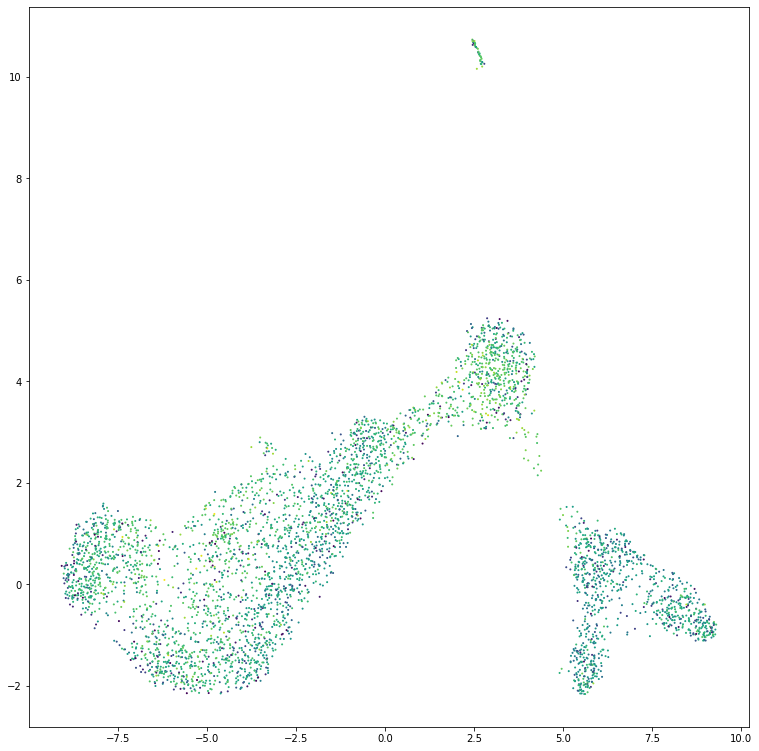

In [73]:
logging.info("Plotting UMAP")
manifold(ds, os.path.join(outdir, 'manifold_UMAP.png'), embedding = 'UMAP')
logging.info("Plotting TSNE")
manifold(ds, os.path.join(outdir, 'manifold_TSNE.png'), embedding = 'TSNE')
logging.info("plotting the number of UMIs")
UMI_plot(ds, os.path.join(outdir, 'manifold_UMI.png'), embedding = 'UMAP')

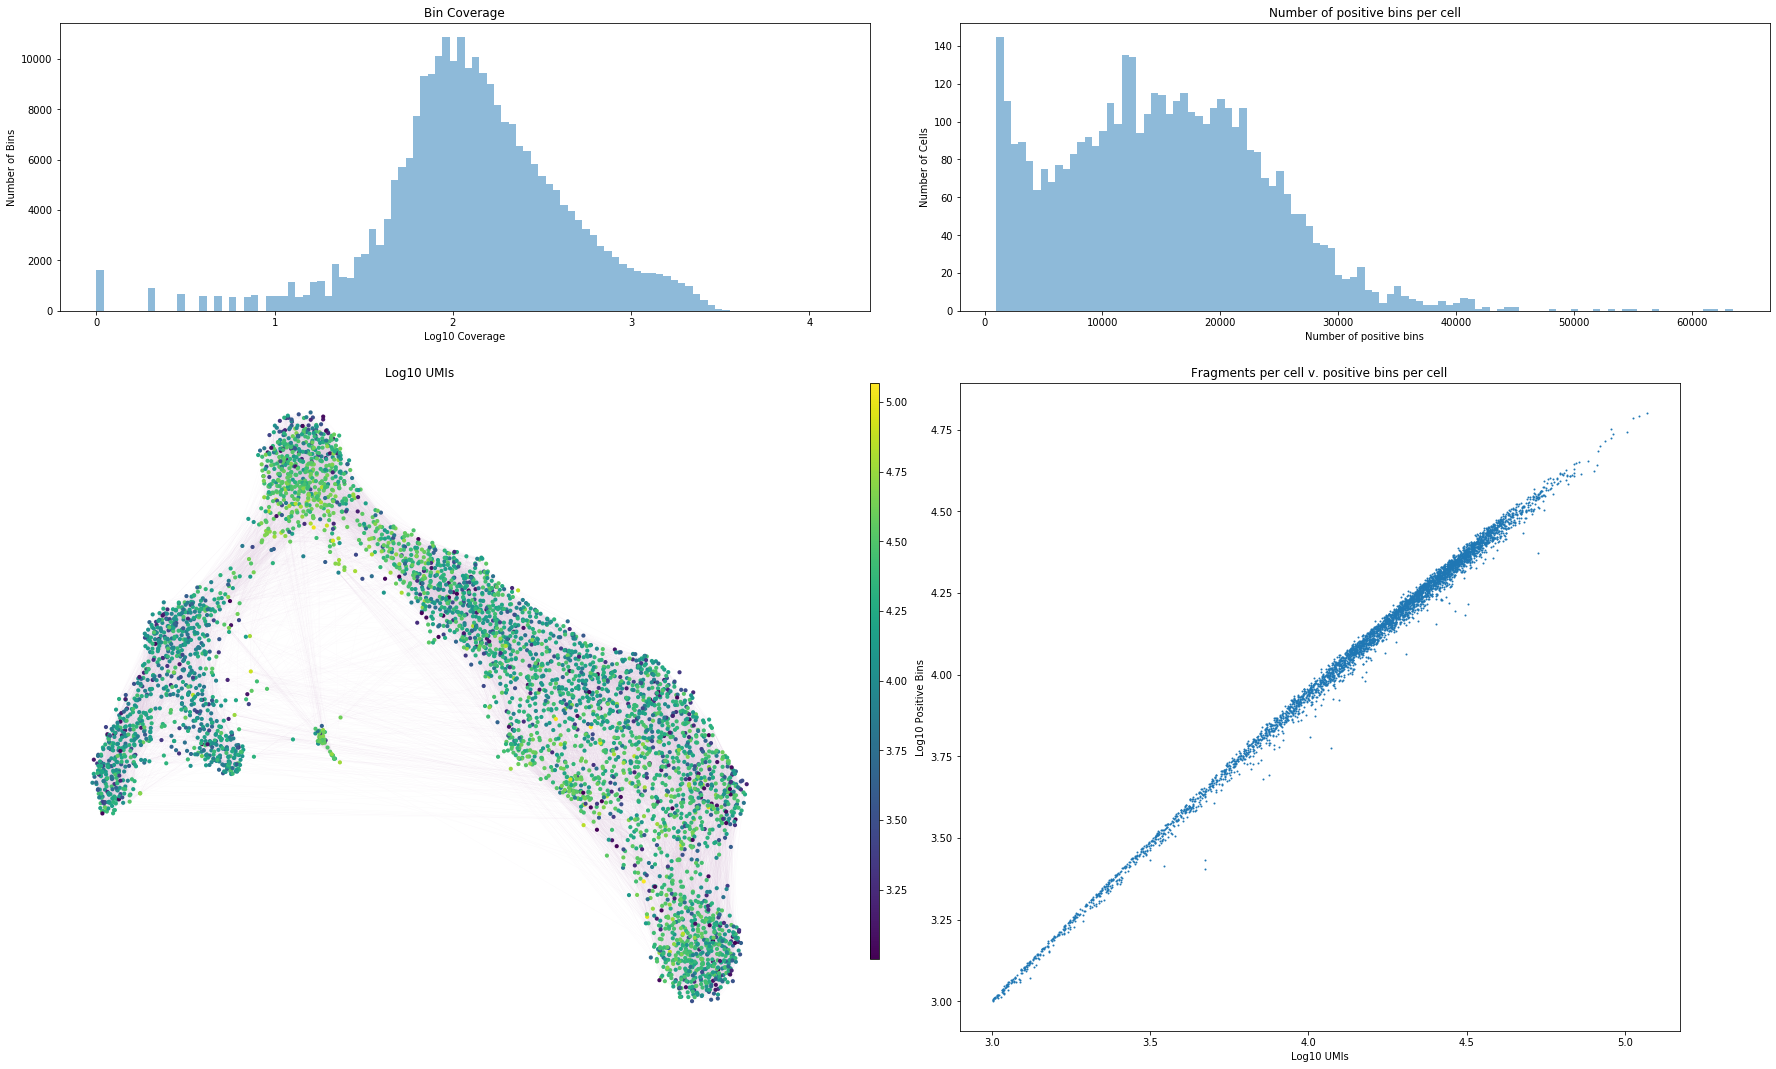

In [69]:
## Add functionality for NBins and histograms

def UMI_plot2(ds: loompy.LoomConnection, out_file: str, embedding: str = "TSNE") -> None:
    '''
    Used to plot the number of fragments on top of the manifold
    '''
    
    n_cells = ds.shape[1]
    has_edges = False
    if "RNN" in ds.col_graphs:
        g = ds.col_graphs.RNN
        has_edges = True
    elif "MKNN" in ds.col_graphs:
        g = ds.col_graphs.MKNN
        has_edges = True
    if embedding in ds.ca:
        pos = ds.ca[embedding]
    else:
        raise ValueError("Embedding not found in the file")
    labels = ds.ca["Clusters"]
    if "Outliers" in ds.col_attrs:
        outliers = ds.col_attrs["Outliers"]
    else:
        outliers = np.zeros(ds.shape[1])
        
    # Compute a good size for the markers, based on local density
    min_pts = 50
    eps_pct = 60
    nn = NearestNeighbors(n_neighbors=min_pts, algorithm="ball_tree", n_jobs=4)
    nn.fit(pos)
    knn = nn.kneighbors_graph(mode='distance')
    k_radius = knn.max(axis=1).toarray()
    epsilon = (2500 / (pos.max() - pos.min())) * np.percentile(k_radius, eps_pct)
    
    fig = plt.figure(figsize=(25, 20))
    ax = fig.add_axes([0, 0, 0.40, 0.45])
    
    # Draw edges
    if has_edges:
        lc = LineCollection(zip(pos[g.row], pos[g.col]), linewidths=0.25, zorder=0, color='thistle', alpha=0.1)
        ax.add_collection(lc)
    
    im = ax.scatter(ds.ca[embedding][:,0],ds.ca[embedding][:,1], cmap='viridis', c=np.log10(ds.ca['passed_filters']), marker='.', lw=0, s=epsilon)
    
    cax = fig.add_axes([0.45, 0.05, 0.005, 0.4])
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_title('Log10 UMIs')
    ax.axis("off")
    
    ## Histogram of Bin Coverage
    ax2 = fig.add_axes([0, 0.5, 0.45, 0.2])

    ax2.hist(np.log10(ds.ra['NCells'][ds.ra['NCells'] > 0]), bins=100, alpha=0.5, range=(0, np.log10(ds.shape[1])+0.5))
    ax2.set_title("Bin Coverage")
    ax2.set_ylabel("Number of Bins")
    ax2.set_xlabel("Log10 Coverage")
    
    ## Histogram of Bins per cell
    ax3 = fig.add_axes([0.5, 0.5, 0.45, 0.2])
    
    ax3.hist(ds.ca['NBins'], bins=100, alpha=0.5)
    ax3.set_title("Number of positive bins per cell")
    ax3.set_ylabel("Number of Cells")
    ax3.set_xlabel("Number of positive bins")
    
    ax4 = fig.add_axes([0.5, 0, 0.40, 0.45])
    ax4.scatter(np.log10(ds.ca['passed_filters']), np.log10(ds.ca['NBins']), s=1)
    ax4.set_title("Fragments per cell v. positive bins per cell")
    ax4.set_ylabel("Log10 Positive Bins")
    ax4.set_xlabel("Log10 UMIs")
    
    fig.savefig(out_file, format="png", dpi=144, bbox_inches='tight')

UMI_plot2(ds, os.path.join(outdir, 'plots_UMI.png'), embedding = 'UMAP')